In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["font.family"] = "Arial"
from skimage import measure
import pyvista as pv
pv.set_jupyter_backend('trame')
from tqdm import tqdm, trange
from scipy import interpolate, ndimage, fft
from scipy.io import savemat
from time import time

## Meshgrid

In [2]:
n_grid = 128
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)

r_grid = np.meshgrid(x,y,z) 


## Random wave

In [3]:
## Maximum entropy distribution of k
def f_maxent(k, sigma_k, a, b, beta):
    f_1 = 1/(2*np.pi*sigma_k)**(3/2)*np.exp(-k**2/2/sigma_k**2)
    f_3_2 = 8*b**3*(a**2+b**2)/np.pi**2/(k**4-2*(a**2-b**2)*k**2+(a**2+b**2)**2)**2

    f_k = beta*f_1 + (1-beta)*f_3_2
    return f_k

def f_gauss(k, mu_k, sigma_k):
    f = 1/(2*np.pi*sigma_k)*np.exp(-(k-mu_k)**2/2/sigma_k**2)
    return f

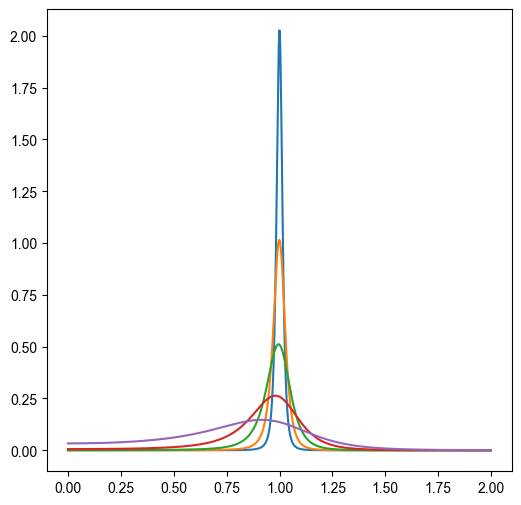

In [4]:
k_list = np.arange(1000)/1000*2
bins = np.arange(1001)/1000*2

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

colors = ['C0','C1','C2','C3','C4']

from lmfit import Minimizer, Parameters, create_params, report_fit, Model

for i, b in enumerate([0.025, 0.05, 0.1, 0.2, 0.4]):
    f_k_list = f_maxent(k_list, sigma_k=0.5, a=1, b=b, beta=0)

    ax.plot(k_list, f_k_list, '-', color=colors[i])

In [5]:
def draw_from_hist(hist, bins, nsamples = 100000):
    cumsum = [0] + list(np.cumsum(hist))
    rand = np.random.rand(nsamples)*max(cumsum)
    return [np.interp(x, cumsum, bins) for x in rand]

In [6]:
#### Superpositioning the random wave ####
def rotation_matrix(axis, phi):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(phi / 2.0)
    b, c, d = -axis * np.sin(phi / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

def sample_wave_MO(r_grid, hist, bins, n_wave = 100, kappa=1e8):
    rho = np.zeros_like(r_grid[0])
    r_grid = [r.astype(np.float32) for r in r_grid]
    for i in range(n_wave):
        phi = np.random.rand()*2*np.pi # random phase
        k_sample = np.array([0,0,draw_from_hist(hist, bins,1)[0]])*np.pi*20

        # misorientation
        """
        https://en.wikipedia.org/wiki/Von_Mises%E2%80%93Fisher_distribution
        https://doi.org/10.1080/03610919408813161
        """
        sigma = 1e-6
        xi = np.random.rand()
        theta = np.random.rand()*2*np.pi
        W = 1+1/kappa*(np.log(xi*(1-(xi-1)/xi*np.exp(-2*kappa))))
        phi = np.arccos(W)
        axis = [np.cos(theta),np.sin(theta),0]
        R = rotation_matrix(axis,phi)
        k_sample_rot = R@k_sample

        k_dot_r = np.sum([r_grid[x]*k_sample_rot[x] for x in range(3)],axis=0)
        rho_i = np.cos(k_dot_r.astype(np.float32) + phi) # cos(k_n.r + phi_n)
        rho += rho_i

    rho = np.sqrt(2/n_wave)*rho
    
    return rho

def scatter_grid(rho, alpha, qq, scale=1, box_size=2):
    """
    Calculates the scattering function S(Q) for a grid density using Fourier transform.

    The function performs the following steps:

    1. Upsamples the grid density by a specified scaling factor using ndimage.zoom().
    2. Clips the upscaled density values to a binary representation (0 or 1) 
       based on the threshold alpha.
    3. Computes the FFT of the binary grid density.
    4. Calculates the scattering function S_q_lmn by squaring the absolute value of the FFT and 
       normalizing by (N/2)^2, where N is the total number of grid points.
    5. Reduces the S_q_lmn
    
    Args:
        rho (ndarray): Grid density.
        alpha (float): Threshold value for density clipping.
        qq (ndarray): Array of Q values.
        scale (int, optional): Scaling factor for upsampling the grid data. Default is 1.
        box_size (float, optional): Size of the simulation box. Default is 2.
    
    Returns:
        ndarray: Scattering function S(Q).
    """
    
    n_grid_scale = rho.shape[0] * scale  # Number of grid points along each dimension
    
    N = (n_grid_scale) ** 3  # Number of grid points after scaling
    
    # Upsampling the grid data with ndimage.zoom()
    rho_bi_zoom = ndimage.zoom(rho, scale, order=1)  # Upscale
    rho_bi = np.zeros_like(rho_bi_zoom)  # Density = 0 or 1
    rho_bi[rho_bi_zoom > alpha] = 1  # Clipped to alpha
    # rho_bi = sigmoid((rho_bi_zoom-alpha)*100)
    
    rho_r = rho_bi
    N_ones = np.sum(rho_r)  # Number of ones
    
    rho_q = np.fft.fftn(rho_r.astype(np.float32))  # FFT of the grid density
    S_q_lmn = np.absolute(rho_q) ** 2  # Scattering function in grid points

    # Reduce S_q_lmn
    grid_coord = np.meshgrid(np.arange(n_grid_scale), np.arange(n_grid_scale), np.arange(n_grid_scale))
    dq_grid = 2 * np.pi / box_size  # Q grid spacing
    q_grid = np.sqrt(grid_coord[0] ** 2 + grid_coord[1] ** 2 + grid_coord[2] ** 2) * dq_grid  # Abs Q value on each grid point

    S_q_lmn = S_q_lmn.astype(np.float32)
    q_grid = q_grid.astype(np.float32)

    nq = len(qq)  # Number of grid points
    d_bins = qq[1] - qq[0]  # Grid spacing
    index_q = np.floor(q_grid/d_bins)  # Index to qq of each grid point

    S_q = np.zeros(nq)  # Allocate output S(Q)
    n_S_q = np.zeros(nq)  # Allocate n_S(Q)

    for iq in range(nq):
        if np.sum(index_q == iq) > 0:
            S_q[iq] = np.nanmean(S_q_lmn[index_q == iq])
    
    return S_q / (N_ones) ** 2

100%|██████████| 20/20 [02:37<00:00,  7.90s/it]


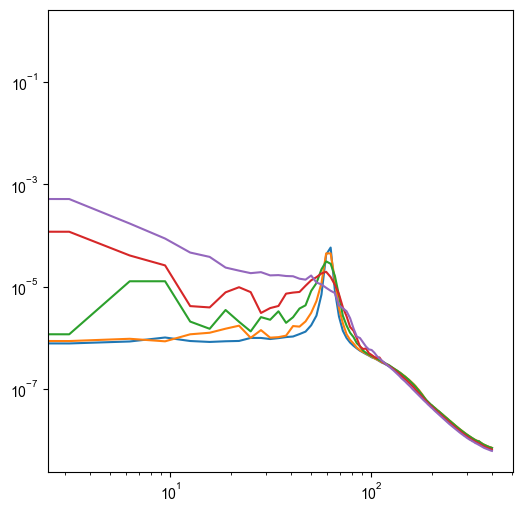

In [7]:
## calculate I(Q)
S_q_b = []

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
for b in [0.025, 0.05, 0.1, 0.2, 0.4]:
    n_sample = 20
    S_q_list = []
    f_k_list = f_maxent(k_list, sigma_k=0.5, a=1, b=b, beta=0)

    for i in trange(n_sample):
        rho = sample_wave_MO(r_grid,hist=f_k_list,bins=bins,n_wave = 100, kappa=1e-4)
        # rho = ball()-0.5

        box_size = 2
        n_grid_scale = 256
        scale = n_grid_scale/rho.shape[0]
        dq = 2*np.pi/box_size
        qq = np.arange(n_grid_scale/2)*dq
        
        S_q_i = scatter_grid(rho,alpha=0,qq=qq,scale=scale)
        S_q_list.append(S_q_i)

    S_q = np.mean(np.array(S_q_list),axis=0)
    S_q_b.append(S_q)

    ax.plot(qq,S_q)
    ax.set_xscale('log')
    ax.set_yscale('log')